In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
nyc_weekly = pd.read_csv('nyc_weekly')

In [3]:
nyc_weekly = nyc_weekly.drop(['Unnamed: 0'], axis=1)

In [4]:
nyc_weekly['log_counts'] = np.log(nyc_weekly['CRIME_SUM'])
nyc_weekly.head()

,Date,CRIME_SUM,log_counts
0,2007-12-31,2473.0,7.813187
1,2008-01-07,2320.0,7.749322
2,2008-01-14,2101.0,7.650169
3,2008-01-21,2160.0,7.677864
4,2008-01-28,2198.0,7.695303


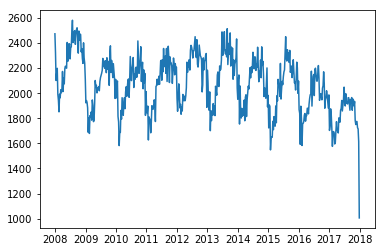

In [5]:
nyc_weekly['Date'] = pd.to_datetime(nyc_weekly['Date'])
plt.plot(nyc_weekly.Date, nyc_weekly.CRIME_SUM)
plt.show()

### Scale the data using MinMaxScaler

In [6]:
crime = nyc_weekly
scaler = MinMaxScaler()
crime_S = scaler.fit_transform(crime.iloc[:,1:2])
crime_S = pd.DataFrame(crime_S, columns=['CRIME_SUM'])

In [7]:
crime_S = pd.concat([crime.Date, crime_S], axis=1)
crime_S.head()

,Date,CRIME_SUM
0,2007-12-31,0.931429
1,2008-01-07,0.834286
2,2008-01-14,0.695238
3,2008-01-21,0.732698
4,2008-01-28,0.756825


### Create dataset for LSTM

In [8]:
def create_dataset(dataset, window_size):
    """
    Creates x and y data sets used for training the LSTM model in the format which is acceptable by Keras API
    Parameters:
        data : crime history (as numpy array)
        window_size : Number of data points to be used to predict/forecast next data point
    
    Returns:
        x : Feature inputs
        y : Target labels
    """
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        # Creating sets of data points (crime) to predict for next week
        data_X.append(dataset[i:(i + window_size), 1]) ## 1 - 'CRIME_SUM' crime from dataframe
        data_Y.append(dataset[i + window_size, 1])
    # Converting list to numpy array
    data_X = np.array(data_X)
    data_Y = np.array(data_Y)
    # Reshaping it according to LSTM input
    x = np.reshape(data_X, (data_X.shape[0], 1, data_X.shape[1]))
    y = np.reshape(data_Y, (data_Y.shape[0], 1, 1))
    return x, y

In [9]:
window_size = 26
x, y = create_dataset(crime_S.values, window_size)

In [11]:
print("number of weeks in the dataset:", crime_S.shape[0])
print("lets take 26 week for the window which makes almost half a year period")
print("confirm 10 year by dividing whole dataset to 2 half a year periods:", crime_S.shape[0]/ (26*2), "year.")

number of weeks in the dataset: 522
lets take 26 week for the window which makes almost half a year period
confirm 10 year by dividing whole dataset to 2 half a year periods: 10.038461538461538 year.


In [10]:
x.shape, y.shape

((495, 1, 26), (495, 1, 1))

### Create the model containing LSTM layers

Input shape of first 'LSTM' layer : (1, window_size)<br>
Output of final 'Dense' layer : 1

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.utils import np_utils

Using TensorFlow backend.


In [11]:
def lstm_model(x, window_size):
    """
    Creates the model which will be used to forecast next week's crime number based on previous values as inputs
    Parameters:
        x : Feature inputs
        window_size : Number of data points to be used to predict/forecast next data point
    
    Returns:
        model : Model architecture created using Keras
    """
    model = Sequential()
    model.add(LSTM(units=32, activation='relu', return_sequences=True, input_shape=(1, window_size)))    # the batch size is neglected!
    model.add(LSTM(units=32, activation='relu'))
    model.add(Dense(1))
    print (model.summary())
    return model

In [11]:
def lstm_model_alt(x, window_size):
    """
    Creates the model which will be used to forecast next week's crime number based on previous values as inputs
    Parameters:
        x : Feature inputs
        window_size : Number of data points to be used to predict/forecast next data point
    
    Returns:
        model : Model architecture created using Keras
    """
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(1, window_size)))    # the batch size is neglected!
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    print (model.summary())
    return model

In [76]:
def lstm_model_alt_2(x, window_size):
    """
    Creates the model which will be used to forecast next week's crime number based on previous values as inputs
    Parameters:
        x : Feature inputs
        window_size : Number of data points to be used to predict/forecast next data point
    
    Returns:
        model : Model architecture created using Keras
    """
    model = Sequential()
    model.add(LSTM(units=100, input_shape=(1, window_size)))    # the batch size is neglected!
    model.add(Dropout(0.5))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    print (model.summary())
    return model

In [68]:
Y = y
Y  = np.reshape(Y, (Y.shape[0], 1))

In [77]:
model = lstm_model_alt_2(x, window_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 100)               50800     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 52,841
Trainable params: 52,841
Non-trainable params: 0
_________________________________________________________________
None


### Compile the model

In [78]:
model.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics = ['mse'])
model.fit(x=x, y=Y, batch_size=16, epochs=50)

Epoch 1/50
495/495 [==============================] - 3s 6ms/step - loss: 0.0252 - mean_squared_error: 0.0252
Epoch 2/50
495/495 [==============================] - 0s 958us/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 3/50
495/495 [==============================] - 1s 1ms/step - loss: 0.0155 - mean_squared_error: 0.0155
Epoch 4/50
495/495 [==============================] - 1s 2ms/step - loss: 0.0142 - mean_squared_error: 0.0142
Epoch 5/50
495/495 [==============================] - 1s 1ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 6/50
495/495 [==============================] - 1s 1ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 7/50
495/495 [==============================] - 1s 2ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 8/50
495/495 [==============================] - 1s 1ms/step - loss: 0.0084 - mean_squared_error: 0.0084
Epoch 9/50
495/495 [==============================] - 1s 1ms/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 10

### Prediction

In [79]:
def predict(data_label, x, window_size, model, scale, batch_size=16):
    """
    Uses trained model to predict on the input set, scales data back to original distribution
    and returns the original dataframe with an added column containing predictions
    
    Parameters:
        data_label : Original??? dataframe of label crime numbers
        x : Feature inputs used to train the model
        batch_size : Batch_size used for training the model
    
    Returns:
        crime_pred : Crime numbers dataframe with an added column containing predictions made by the trained model
    """
    preds = []
    data_label.reset_index(drop=True, inplace=True)
    # Iterating over training samples
    for i in range(len(x)):
        data = np.reshape(x[i], (1, 1, 26))
        # Predicting from the trained model
        preds.append(model.predict(x=data, batch_size=batch_size)[0][0])

    predictions = np.copy(scale.inverse_transform(np.array(preds).reshape(-1, 1)))
    data_label.loc[window_size+1:,'Predictions'] = np.copy(predictions)
    data_label.iloc[:,1] = np.copy(scale.inverse_transform(data_label.iloc[:,1].values.reshape(-1, 1)))
    return data_label

In [80]:
crimes = predict(crime_S, x, window_size, model, scaler)

In [374]:
def plot_predictions(crimes, title, idx1=27):
    """
    Plots the predictions on top of crime numbers history
    
    Parameters:
        crimes : Original dataframe of crime numbers
        title : Title of the plot
    
    Returns:
        crimes : Crime numbers dataframe with an added column containing predictions made by the trained model
    """
    idx2=len(crimes)-1
    plt.figure(figsize=(7, 5))
    plt.plot(crimes.Date[idx1:idx2], crimes.Predictions[idx1:idx2], label='Predictions', color='red')
    plt.plot(crimes.Date[idx1:idx2], crimes.iloc[:,1][idx1:idx2], label='actual', color='green')
    plt.xlabel("Year")
    plt.ylabel("Crime")
    plt.title(title)
    plt.legend()
    plt.show()

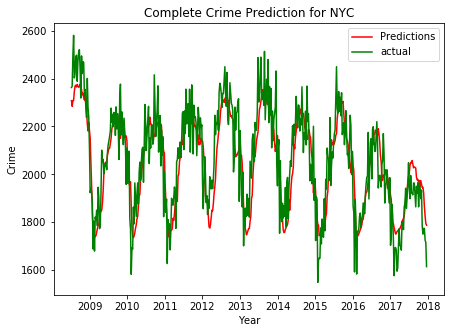

In [375]:
title = "Complete Crime Prediction for NYC"
plot_predictions(crimes, title)

In [344]:
print('RMSE for Whole crimes:', ((crimes[27:].CRIME_SUM - crimes[27:].Predictions) ** 2).mean() ** .5)

RMSE for Whole crimes: 115.7003998912949


In [346]:
crimes.CRIME_SUM.mean(), crimes.CRIME_SUM.std() 

(2069.235632183908, 217.36398450649554)

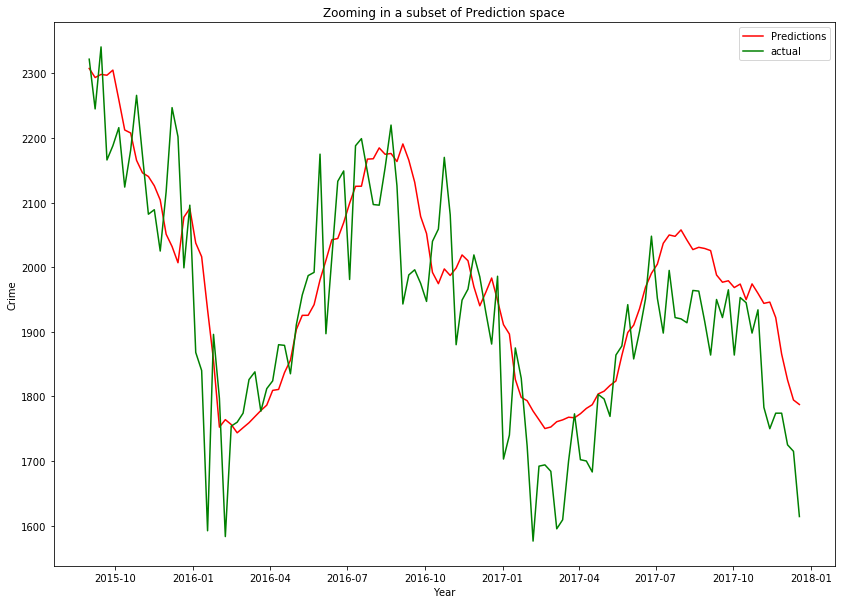

In [86]:
# Same function to zoom in on a particular sub-space of predictions
title = "Zooming in a subset of Prediction space"
plot_predictions(crimes, title)

### Predicting clustered dataframe (our five clusters)

In [14]:
df_clustered = pd.read_csv('df_clustered')

In [15]:
df_clustered = df_clustered.rename(index=str, columns={"Unnamed: 0": "Date"})

In [16]:
df_clustered['Date'] = pd.to_datetime(df_clustered['Date'])

In [17]:
df_clustered[-10:]

,Date,Label0,Label1,Label2,Label3,Label4
512,2017-10-23,246.0,487.0,464.0,433.0,267.0
513,2017-10-30,247.0,493.0,484.0,481.0,229.0
514,2017-11-06,216.0,448.0,455.0,435.0,229.0
515,2017-11-13,214.0,486.0,427.0,393.0,230.0
516,2017-11-20,234.0,447.0,482.0,391.0,220.0
517,2017-11-27,219.0,495.0,438.0,384.0,238.0
518,2017-12-04,224.0,454.0,451.0,365.0,231.0
519,2017-12-11,231.0,451.0,443.0,367.0,223.0
520,2017-12-18,254.0,402.0,370.0,356.0,231.0
521,2017-12-25,134.0,274.0,227.0,238.0,132.0


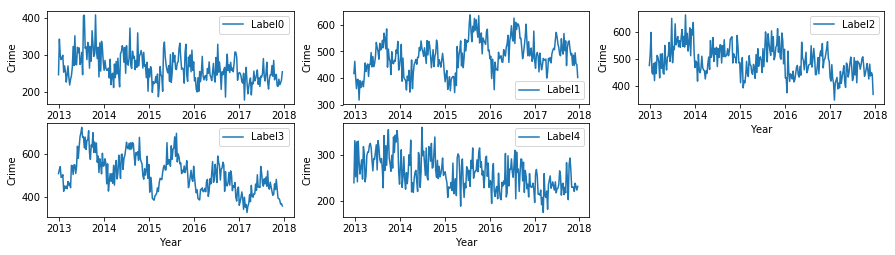

In [369]:
fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(531)
ax1.plot(df_clustered.Date[260:521], df_clustered['Label0'][260:521])
plt.ylabel('Crime')
plt.xlabel('Year')
plt.legend()

ax2 = fig.add_subplot(532)
ax2.plot(df_clustered.Date[260:521], df_clustered['Label1'][260:521])
plt.ylabel('Crime')
plt.xlabel('Year')
plt.legend()

ax3 = fig.add_subplot(533)
ax3.plot(df_clustered.Date[260:521], df_clustered['Label2'][260:521])
plt.ylabel('Crime')
plt.xlabel('Year')
plt.legend()

ax4 = fig.add_subplot(534)
ax4.plot(df_clustered.Date[260:521], df_clustered['Label3'][260:521])
plt.ylabel('Crime')
plt.xlabel('Year')
plt.legend()

ax5 = fig.add_subplot(535)
ax5.plot(df_clustered.Date[260:521], df_clustered['Label4'][260:521])
plt.ylabel('Crime')
plt.xlabel('Year')
plt.legend()

plt.show()

### Scale the data using MinMaxScaler

In [19]:
df_clustered = df_clustered[:521]

In [20]:
df_clustered.iloc[:,1:6].head()

,Label0,Label1,Label2,Label3,Label4
0,346.0,491.0,778.0,517.0,338.0
1,267.0,425.0,776.0,533.0,315.0
2,254.0,378.0,692.0,456.0,321.0
3,248.0,402.0,700.0,487.0,322.0
4,272.0,379.0,774.0,428.0,344.0


In [88]:
## Label0
scaler0 = MinMaxScaler()
Label0_S = scaler0.fit_transform(df_clustered.iloc[:,1:2])
Label0_S = pd.DataFrame(Label0_S, columns=['Label0'])
Label0_S['Date'] = df_clustered.Date.values
cols0 = Label0_S.columns.tolist()
cols0 = cols0[-1:] + cols0[:-1]
Label0_S = Label0_S[cols0]
Label0 = Label0_S[104:]

In [89]:
## Label1
scaler1 = MinMaxScaler()
Label1_S = scaler1.fit_transform(df_clustered.iloc[:,2:3])
Label1_S = pd.DataFrame(Label1_S, columns=['Label1'])
Label1_S['Date'] = df_clustered.Date.values
cols1 = Label1_S.columns.tolist()
cols1 = cols1[-1:] + cols1[:-1]
Label1_S = Label1_S[cols1]
Label1 = Label1_S[104:]

In [90]:
## Label2
scaler2 = MinMaxScaler()
Label2_S = scaler2.fit_transform(df_clustered.iloc[:,3:4])
Label2_S = pd.DataFrame(Label2_S, columns=['Label2'])
Label2_S['Date'] = df_clustered.Date.values
cols2 = Label2_S.columns.tolist()
cols2 = cols2[-1:] + cols2[:-1]
Label2_S = Label2_S[cols2]
Label2 = Label2_S[104:]

In [91]:
## Label3
scaler3 = MinMaxScaler()
Label3_S = scaler3.fit_transform(df_clustered.iloc[:,4:5])
Label3_S = pd.DataFrame(Label3_S, columns=['Label3'])
Label3_S['Date'] = df_clustered.Date.values
cols3 = Label3_S.columns.tolist()
cols3 = cols3[-1:] + cols3[:-1]
Label3_S = Label3_S[cols3]
Label3 = Label3_S[104:]

In [92]:
## Label4
scaler4 = MinMaxScaler()
Label4_S = scaler4.fit_transform(df_clustered.iloc[:,5:6])
Label4_S = pd.DataFrame(Label4_S, columns=['Label4'])
Label4_S['Date'] = df_clustered.Date.values
cols4 = Label4_S.columns.tolist()
cols4 = cols4[-1:] + cols4[:-1]
Label4_S = Label4_S[cols4]
Label4 = Label4_S[104:]

In [511]:
min(Label1[:-51].Date), max(Label1[:-51].Date)

(Timestamp('2009-12-28 00:00:00'), Timestamp('2016-12-26 00:00:00'))

In [512]:
min(Label1[314:].Date), max(Label1[314:].Date)

(Timestamp('2016-01-04 00:00:00'), Timestamp('2017-12-18 00:00:00'))

In [93]:
Label1_train = Label1[:-51]
Label1_test = Label1[314:]

In [94]:
Label0_train = Label0[:-51]
Label0_test = Label0[314:]

In [95]:
Label2_train = Label2[:-51]
Label2_test = Label2[314:]

In [96]:
Label3_train = Label3[:-51]
Label3_test = Label3[314:]

In [97]:
Label4_train = Label4[:-51]
Label4_test = Label4[314:]

#### Creating dataset for LSTM

In [98]:
window_size = 26

In [99]:
x_1_train, y_1_train = create_dataset(Label1_train.values, window_size)
x_1_test, y_1_test = create_dataset(Label1_test.values, window_size)

In [100]:
x_0_train, y_0_train = create_dataset(Label0_train.values, window_size)
x_0_test, y_0_test = create_dataset(Label0_test.values, window_size)

x_2_train, y_2_train = create_dataset(Label2_train.values, window_size)
x_2_test, y_2_test = create_dataset(Label2_test.values, window_size)

x_3_train, y_3_train = create_dataset(Label3_train.values, window_size)
x_3_test, y_3_test = create_dataset(Label3_test.values, window_size)

x_4_train, y_4_train = create_dataset(Label4_train.values, window_size)
x_4_test, y_4_test = create_dataset(Label4_test.values, window_size)

In [101]:
print("number of weeks in the dataset:", Label1_train.shape[0])
print("lets take 26 week for the window which makes almost half a year period")
print("confirm 5 year by dividing whole dataset to 2 half a year periods:", Label1_train.shape[0]/ (26*2), "year.")

number of weeks in the dataset: 366
lets take 26 week for the window which makes almost half a year period
confirm 5 year by dividing whole dataset to 2 half a year periods: 7.038461538461538 year.


In [102]:
x_1_train.shape, y_1_train.shape

((339, 1, 26), (339, 1, 1))

In [103]:
Y_1_train = y_1_train
Y_1_test = y_1_test

In [104]:
Y_0_train = y_0_train
Y_0_test = y_0_test

Y_2_train = y_2_train
Y_2_test = y_2_test

Y_3_train = y_3_train
Y_3_test = y_3_test

Y_4_train = y_4_train
Y_4_test = y_4_test

In [105]:
Y_1_train = np.reshape(Y_1_train, (Y_1_train.shape[0], 1))
Y_1_test = np.reshape(Y_1_test, (Y_1_test.shape[0], 1))

In [106]:
Y_0_train = np.reshape(Y_0_train, (Y_0_train.shape[0], 1))
Y_0_test = np.reshape(Y_0_test, (Y_0_test.shape[0], 1))

Y_2_train = np.reshape(Y_2_train, (Y_2_train.shape[0], 1))
Y_2_test = np.reshape(Y_2_test, (Y_2_test.shape[0], 1))

Y_3_train = np.reshape(Y_3_train, (Y_3_train.shape[0], 1))
Y_3_test = np.reshape(Y_3_test, (Y_3_test.shape[0], 1))

Y_4_train = np.reshape(Y_4_train, (Y_4_train.shape[0], 1))
Y_4_test = np.reshape(Y_4_test, (Y_4_test.shape[0], 1))

In [108]:
model_1 = lstm_model_alt_2(x_1_train, window_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 100)               50800     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 21        
Total params: 52,841
Trainable params: 52,841
Non-trainable params: 0
_________________________________________________________________
None


In [113]:
model_0 = lstm_model_alt_2(x_0_train, window_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 100)               50800     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 52,841
Trainable params: 52,841
Non-trainable params: 0
_________________________________________________________________
None


In [118]:
model_2 = lstm_model_alt_2(x_2_train, window_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 100)               50800     
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 21        
Total params: 52,841
Trainable params: 52,841
Non-trainable params: 0
_________________________________________________________________
None


In [124]:
model_3 = lstm_model_alt_2(x_3_train, window_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 100)               50800     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 21        
Total params: 52,841
Trainable params: 52,841
Non-trainable params: 0
_________________________________________________________________
None


In [138]:
model_4 = lstm_model_alt_2(x_4_train, window_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 100)               50800     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 21        
Total params: 52,841
Trainable params: 52,841
Non-trainable params: 0
_________________________________________________________________
None


### Compile the model

#### Beware the clusters have changed from the last time(you gotta use random.seed() to get the same results each time)

#### Important Note: LSTM cannot get the tops and bottoms very well, at least for the Label0.
- I also tried to increase number of units, adding more layers; nothing changed much.
- Maybe increasing the timeframe and/or adding dropouts/normalization may be helpful.
- See also prediction results with only using auto-regressive timeseries.
- Try to change the LSTM architecture and hyperparameters(learning rate, activation function, optimizer, loss??) I tried but best option seems to be the below.

#### Update: It works better with Label1(apperantly depends very much on whether data shows a good periodicity or not)

In [ ]:
## alternative optimizer
## sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [109]:
model_1.compile(optimizer='RMSprop',
            loss='mean_squared_error',
            metrics = ['mse'])
history_1 = model_1.fit(x_1_train, Y_1_train, batch_size=16, epochs=50, validation_data=(x_1_test, Y_1_test))

Train on 339 samples, validate on 76 samples
Epoch 1/50
339/339 [==============================] - 3s 8ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0274 - val_mean_squared_error: 0.0274
Epoch 2/50
339/339 [==============================] - 0s 1ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 3/50
339/339 [==============================] - 0s 950us/step - loss: 0.0272 - mean_squared_error: 0.0272 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 4/50
339/339 [==============================] - 0s 1ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0211 - val_mean_squared_error: 0.0211
Epoch 5/50
339/339 [==============================] - 0s 1ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 6/50
339/339 [==============================] - 0s 976us/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0405 - val_mean_s

In [114]:
model_0.compile(optimizer='RMSprop',
            loss='mean_squared_error',
            metrics = ['mse'])
history_0 = model_0.fit(x_0_train, Y_0_train, batch_size=16, epochs=50, validation_data=(x_0_test, Y_0_test))

Train on 339 samples, validate on 76 samples
Epoch 1/50
339/339 [==============================] - 3s 9ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 2/50
339/339 [==============================] - 1s 2ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 3/50
339/339 [==============================] - 0s 987us/step - loss: 0.0275 - mean_squared_error: 0.0275 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 4/50
339/339 [==============================] - 0s 908us/step - loss: 0.0270 - mean_squared_error: 0.0270 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 5/50
339/339 [==============================] - 0s 848us/step - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 6/50
339/339 [==============================] - 1s 2ms/step - loss: 0.0259 - mean_squared_error: 0.0259 - val_loss: 0.0338 - val_mean

In [119]:
model_2.compile(optimizer='RMSprop',
            loss='mean_squared_error',
            metrics = ['mse'])
history_2 = model_2.fit(x_2_train, Y_2_train, batch_size=16, epochs=50, validation_data=(x_2_test, Y_2_test))

Train on 339 samples, validate on 76 samples
Epoch 1/50
339/339 [==============================] - 3s 8ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 2/50
339/339 [==============================] - 0s 1ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 3/50
339/339 [==============================] - 0s 964us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 4/50
339/339 [==============================] - 0s 907us/step - loss: 0.0129 - mean_squared_error: 0.0129 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 5/50
339/339 [==============================] - 0s 967us/step - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 6/50
339/339 [==============================] - 0s 943us/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0264 - val_me

In [125]:
model_3.compile(optimizer='RMSprop',
            loss='mean_squared_error',
            metrics = ['mse'])
history_3 = model_3.fit(x_3_train, Y_3_train, batch_size=16, epochs=50, validation_data=(x_3_test, Y_3_test))

Train on 339 samples, validate on 76 samples
Epoch 1/50
339/339 [==============================] - 4s 11ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0689 - val_mean_squared_error: 0.0689
Epoch 2/50
339/339 [==============================] - 0s 1ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0543 - val_mean_squared_error: 0.0543
Epoch 3/50
339/339 [==============================] - 0s 1ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0518 - val_mean_squared_error: 0.0518
Epoch 4/50
339/339 [==============================] - 0s 1ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - val_loss: 0.0541 - val_mean_squared_error: 0.0541
Epoch 5/50
339/339 [==============================] - 1s 2ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0653 - val_mean_squared_error: 0.0653
Epoch 6/50
339/339 [==============================] - 0s 1ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0420 - val_mean_squa

In [139]:
model_4.compile(optimizer='RMSprop',
            loss='mean_squared_error',
            metrics = ['mse'])
history_4 = model_4.fit(x_4_train, Y_4_train, batch_size=16, epochs=50, validation_data=(x_4_test, Y_4_test))

Train on 339 samples, validate on 76 samples
Epoch 1/50
339/339 [==============================] - 4s 11ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0515 - val_mean_squared_error: 0.0515
Epoch 2/50
339/339 [==============================] - 0s 1ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0487 - val_mean_squared_error: 0.0487
Epoch 3/50
339/339 [==============================] - 1s 3ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 4/50
339/339 [==============================] - 0s 1ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0392 - val_mean_squared_error: 0.0392
Epoch 5/50
339/339 [==============================] - 1s 2ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 6/50
339/339 [==============================] - 0s 1ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0433 - val_mean_squa

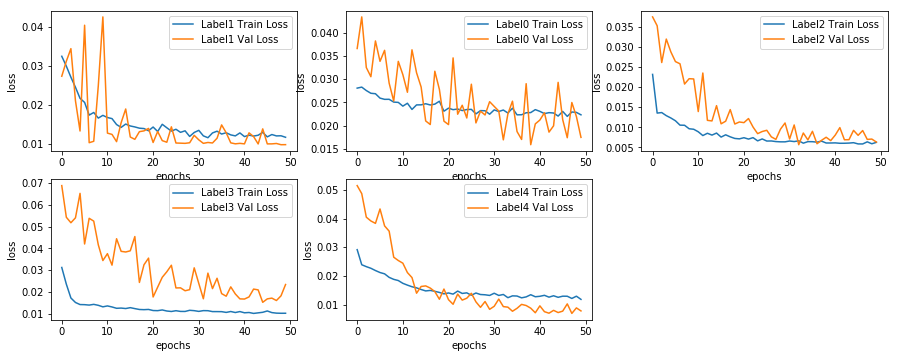

In [368]:
fig = plt.figure(figsize = (15,15))

ax1 = fig.add_subplot(531)
ax1.plot(history_1.history['loss'], label='Label1 Train Loss')
ax1.plot(history_1.history['val_loss'], label='Label1 Val Loss')
#plt.title('model loss Label1', size=10)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

ax2 = fig.add_subplot(532)
ax2.plot(history_0.history['loss'], label='Label0 Train Loss')
ax2.plot(history_0.history['val_loss'], label='Label0 Val Loss')
#plt.title('model loss Label0', size=10)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

ax3 = fig.add_subplot(533)
ax3.plot(history_2.history['loss'], label='Label2 Train Loss')
ax3.plot(history_2.history['val_loss'], label='Label2 Val Loss')
#plt.title('model loss Label2', size=10)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

ax4 = fig.add_subplot(534)
ax4.plot(history_3.history['loss'], label='Label3 Train Loss')
ax4.plot(history_3.history['val_loss'], label='Label3 Val Loss')
#plt.title('model loss Label3', size=10)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

ax5 = fig.add_subplot(535)
ax5.plot(history_4.history['loss'], label='Label4 Train Loss')
ax5.plot(history_4.history['val_loss'], label='Label4 Val Loss')
#plt.title('model loss Label4', size=10)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

plt.show();

In [111]:
Label1_pred = predict(Label1_test, x_1_test, window_size, model_1, scaler1)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [116]:
Label0_pred = predict(Label0_test, x_0_test, window_size, model_0, scaler0)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [121]:
Label2_pred = predict(Label2_test, x_2_test, window_size, model_2, scaler2)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [141]:
Label4_pred = predict(Label4_test, x_4_test, window_size, model_4, scaler4)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

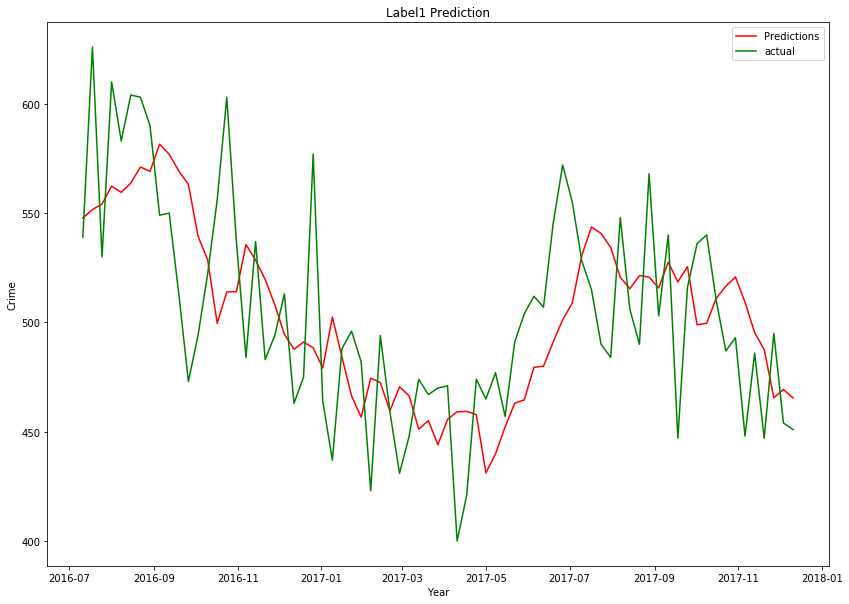

In [112]:
plot_predictions(Label1_pred, "Label1 Prediction")

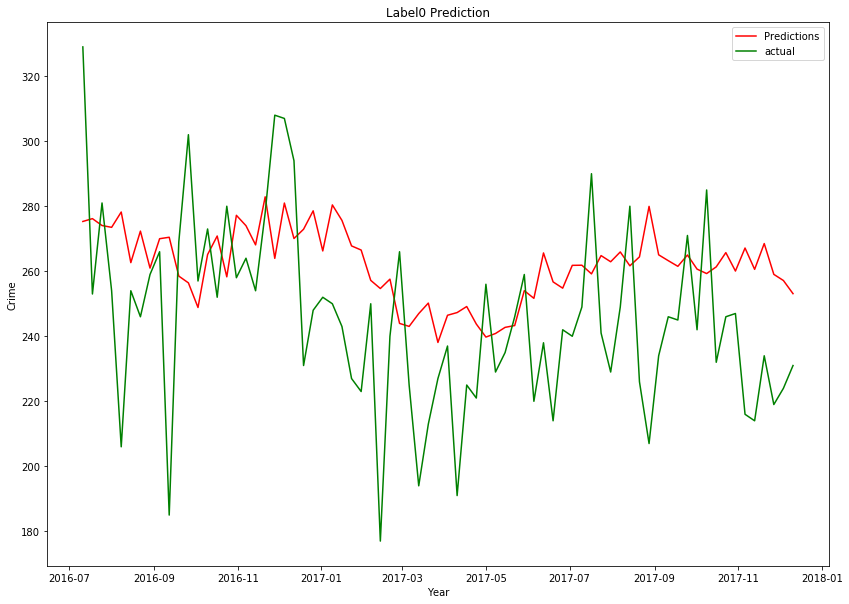

In [117]:
plot_predictions(Label0_pred, "Label0 Prediction")

In [61]:
df_clustered.iloc[445:, :].head(10)

,Date,Label0,Label1,Label2,Label3,Label4
445,2016-07-11,329.0,539.0,478.0,591.0,251.0
446,2016-07-18,253.0,626.0,480.0,562.0,278.0
447,2016-07-25,281.0,530.0,482.0,545.0,310.0
448,2016-08-01,254.0,610.0,550.0,478.0,204.0
449,2016-08-08,206.0,583.0,471.0,530.0,306.0
450,2016-08-15,254.0,604.0,500.0,534.0,262.0
451,2016-08-22,246.0,603.0,540.0,562.0,269.0
452,2016-08-29,259.0,590.0,507.0,550.0,220.0
453,2016-09-05,266.0,549.0,443.0,425.0,260.0
454,2016-09-12,185.0,550.0,443.0,517.0,291.0


In [60]:
Label2_pred.iloc[27:,:].head()

,Date,Label2,Predictions
27,2016-07-11,478.0,540.748413
28,2016-07-18,480.0,544.482178
29,2016-07-25,482.0,540.322998
30,2016-08-01,550.0,527.290894
31,2016-08-08,471.0,534.906067


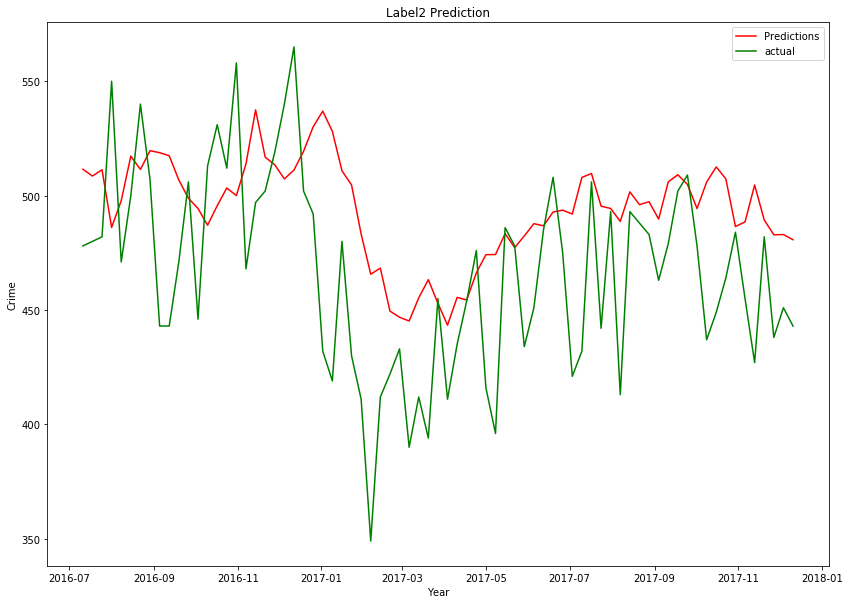

In [122]:
plot_predictions(Label2_pred, "Label2 Prediction")

In [131]:
Label3_pred = predict(Label3_test, x_3_test, window_size, model_3, scaler3)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

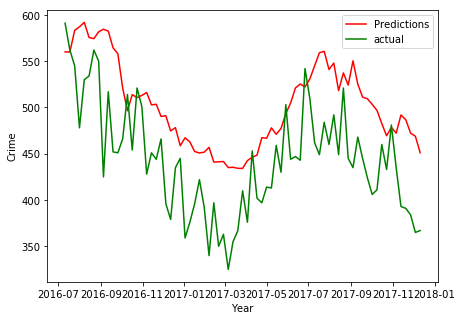

In [376]:
plot_predictions(Label3_pred, "")

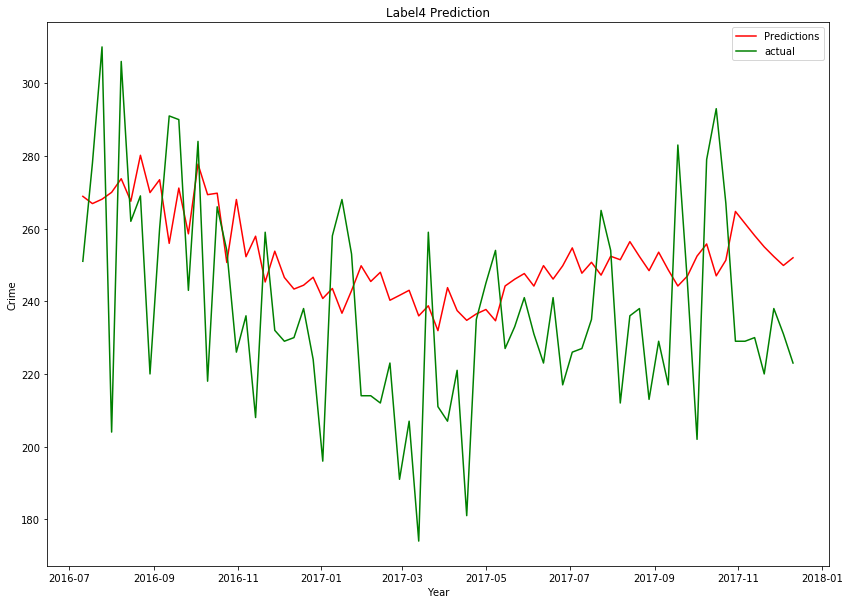

In [142]:
plot_predictions(Label4_pred, "Label4 Prediction")

In [342]:
## RMSE for each Label
print('RMSE for Label0:', ((Label0_pred[27:].Label0 - Label0_pred[27:].Predictions) ** 2).mean() ** .5)
print('RMSE for Label1:', ((Label1_pred[27:].Label1 - Label1_pred[27:].Predictions) ** 2).mean() ** .5)
print('RMSE for Label2:', ((Label2_pred[27:].Label2 - Label2_pred[27:].Predictions) ** 2).mean() ** .5)
print('RMSE for Label3:', ((Label3_pred[27:].Label3 - Label3_pred[27:].Predictions) ** 2).mean() ** .5)
print('RMSE for Label4:', ((Label4_pred[27:].Label4 - Label4_pred[27:].Predictions) ** 2).mean() ** .5)

RMSE for Label0: 31.76891068388397
RMSE for Label1: 39.37989667655653
RMSE for Label2: 47.85370701013327
RMSE for Label3: 70.98747534812293
RMSE for Label4: 29.046056410454597


## Translating the results to census tract level 

In [156]:
Label1_test.iloc[52:,:].head()

,Date,Label1,Predictions
52,2017-01-02,464.0,479.141418
53,2017-01-09,437.0,502.454407
54,2017-01-16,488.0,484.176636
55,2017-01-23,496.0,466.442657
56,2017-01-30,482.0,456.653900


#### Multiplying the prediction values with borough distributions 

In [157]:
clusters_tract_level = pd.read_csv('clusters_tract_level')

In [389]:
tracts_Label0 = clusters_tract_level[clusters_tract_level.labels1 == 0]
tracts_Label1 = clusters_tract_level[clusters_tract_level.labels1 == 1]
tracts_Label2 = clusters_tract_level[clusters_tract_level.labels1 == 2]
tracts_Label3 = clusters_tract_level[clusters_tract_level.labels1 == 3]
tracts_Label4 = clusters_tract_level[clusters_tract_level.labels1 == 4]

### Label1

In [390]:
tracts_Label1_edit = tracts_Label1.T

In [391]:
new_header = tracts_Label1_edit.iloc[0] 
tracts_Label1_edit = tracts_Label1_edit[1:] 
tracts_Label1_edit.columns = new_header

In [392]:
tracts_Label1_edit = tracts_Label1_edit.rolling(window=26).mean()

In [393]:
tracts_Label1_edit = tracts_Label1_edit[470:-2].T

In [394]:
tracts_Label1_edit = tracts_Label1_edit / tracts_Label1_edit.sum()

In [395]:
tracts_Label1_edit.head()

,2017-01-02 00:00:00,2017-01-09 00:00:00,2017-01-16 00:00:00,2017-01-23 00:00:00,2017-01-30 00:00:00,2017-02-06 00:00:00,2017-02-13 00:00:00,2017-02-20 00:00:00,2017-02-27 00:00:00,2017-03-06 00:00:00,...,2017-10-16 00:00:00,2017-10-23 00:00:00,2017-10-30 00:00:00,2017-11-06 00:00:00,2017-11-13 00:00:00,2017-11-20 00:00:00,2017-11-27 00:00:00,2017-12-04 00:00:00,2017-12-11 00:00:00,2017-12-18 00:00:00
boro_ct201,,,,,,,,,,,,,,,,,,,,,
1000201.0,0.001145,0.001154,0.001165,0.001168,0.001179,0.001044,0.000902,0.000836,0.000846,0.000775,...,0.001130,0.001204,0.001126,0.001128,0.001126,0.001130,0.001055,0.000984,0.001064,0.001076
1000600.0,0.004008,0.004110,0.004078,0.004161,0.004053,0.004176,0.004436,0.004333,0.004309,0.004420,...,0.004066,0.004138,0.004204,0.004364,0.004429,0.004745,0.004824,0.004618,0.004637,0.004688
1000900.0,0.003078,0.003028,0.002913,0.002847,0.002506,0.002685,0.002556,0.002508,0.002616,0.002869,...,0.003238,0.003235,0.002928,0.002859,0.003078,0.003239,0.003467,0.003482,0.003573,0.003535
1001002.0,0.002076,0.002091,0.002185,0.002044,0.002063,0.001864,0.001805,0.001824,0.002000,0.002016,...,0.002108,0.002257,0.002252,0.002407,0.002327,0.002335,0.002261,0.002195,0.002129,0.002229
1001200.0,0.002219,0.002019,0.002112,0.001898,0.001916,0.002088,0.002105,0.002128,0.001924,0.002016,...,0.002560,0.002633,0.002702,0.002934,0.003228,0.003013,0.002789,0.002650,0.002661,0.002383


In [396]:
Label1_series = Label1_test.iloc[52:,:].T

In [397]:
new_header = Label1_series.iloc[0] 
Label1_series = Label1_series[1:] 
Label1_series.columns = new_header

In [398]:
sum_Label1 = Label1_series.iloc[1:]

In [399]:
tracts_Label1_pred = pd.DataFrame(tracts_Label1_edit.values*sum_Label1.values, 
                                  columns=tracts_Label1_edit.columns, index=tracts_Label1_edit.index)

#### ---- Changing the method to weekly tract comparison ----

In [400]:
tracts_Label1_pred.head()

,2017-01-02 00:00:00,2017-01-09 00:00:00,2017-01-16 00:00:00,2017-01-23 00:00:00,2017-01-30 00:00:00,2017-02-06 00:00:00,2017-02-13 00:00:00,2017-02-20 00:00:00,2017-02-27 00:00:00,2017-03-06 00:00:00,...,2017-10-16 00:00:00,2017-10-23 00:00:00,2017-10-30 00:00:00,2017-11-06 00:00:00,2017-11-13 00:00:00,2017-11-20 00:00:00,2017-11-27 00:00:00,2017-12-04 00:00:00,2017-12-11 00:00:00,2017-12-18 00:00:00
boro_ct201,,,,,,,,,,,,,,,,,,,,,
1000201.0,0.548688,0.579616,0.564144,0.54483,0.538428,0.495399,0.426275,0.384263,0.398283,0.361671,...,0.577236,0.621744,0.586445,0.574637,0.557847,0.55081,0.491225,0.461883,0.495373,0.501152
1000600.0,1.92041,2.06488,1.9745,1.94096,1.85084,1.9816,2.09585,1.99118,2.02762,2.06153,...,2.07805,2.13725,2.18939,2.22193,2.1942,2.3134,2.2456,2.1673,2.15841,2.18359
1000900.0,1.4746,1.52149,1.41036,1.32802,1.14416,1.27388,1.20778,1.15279,1.23106,1.33818,...,1.65474,1.67094,1.52476,1.45575,1.52478,1.57899,1.61403,1.63435,1.66304,1.64664
1001002.0,0.994496,1.05055,1.05777,0.953453,0.942248,0.884641,0.85255,0.838392,0.941395,0.940345,...,1.07751,1.16577,1.17289,1.22589,1.15288,1.13834,1.05263,1.03035,0.990746,1.0381
1001200.0,1.06308,1.01433,1.02251,0.885349,0.874945,0.990798,0.994641,0.978124,0.905188,0.940345,...,1.3084,1.36007,1.40747,1.49406,1.59916,1.46883,1.29824,1.24353,1.23843,1.10969


In [169]:
## tracts_Label1_pred['Total_1y'] = tracts_Label1_pred.sum(axis=1)

In [401]:
## tracts_Label1_pred[['Total_1y']].sort_values(by='Total_1y', ascending=False).head()

#### Getting the sum of real values for the last year 

In [171]:
df1 = tracts_Label1.iloc[:,:1]

In [172]:
df2 = tracts_Label1.iloc[:,471:-2]

In [180]:
tracts_Label1_real = pd.concat([df1, df2], axis=1)

In [186]:
tracts_Label1_real = tracts_Label1_real.set_index('boro_ct201')

In [187]:
tracts_Label1_real['Total_1y_real'] = tracts_Label1_real.sum(axis=1)

In [402]:
tracts_Label1_real.head()

,2017-01-02 00:00:00,2017-01-09 00:00:00,2017-01-16 00:00:00,2017-01-23 00:00:00,2017-01-30 00:00:00,2017-02-06 00:00:00,2017-02-13 00:00:00,2017-02-20 00:00:00,2017-02-27 00:00:00,2017-03-06 00:00:00,...,2017-10-23 00:00:00,2017-10-30 00:00:00,2017-11-06 00:00:00,2017-11-13 00:00:00,2017-11-20 00:00:00,2017-11-27 00:00:00,2017-12-04 00:00:00,2017-12-11 00:00:00,2017-12-18 00:00:00,Total_1y_real
boro_ct201,,,,,,,,,,,,,,,,,,,,,
1000201,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,20.0
1000600,3.0,2.0,2.0,2.0,0.0,2.0,3.0,0.0,1.0,5.0,...,2.0,4.0,2.0,3.0,5.0,3.0,2.0,1.0,2.0,104.0
1000900,1.0,1.0,1.0,2.0,1.0,2.0,0.0,2.0,2.0,5.0,...,1.0,0.0,0.0,4.0,3.0,3.0,1.0,3.0,2.0,91.0
1001002,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,0.0,...,2.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,50.0
1001200,0.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,...,1.0,1.0,3.0,4.0,0.0,0.0,0.0,3.0,2.0,60.0


#### define function for calculating real and pred top tracts in weekly fashion 

In [605]:
def weekly_check(real, pred):
    dicts_real = {}
    dicts_pred = {}
    
    for i in range(51):
        for j in range(50):
            R = real.iloc[:,i].sort_values(ascending=False).iloc[0:j+1]
            real_value = R.sum()
            if i in dicts_real:
                dicts_real[i].append(real_value)
            else:
                dicts_real[i] = [real_value]
                
            P = pred.iloc[:,i].sort_values(ascending=False).iloc[0:j+1].to_frame()    
            pred_value = P.merge(R.to_frame(), left_index=True, right_index=True).iloc[:,0].sum()
            if i in dicts_pred:
                dicts_pred[i].append(pred_value)
            else:
                dicts_pred[i] = [pred_value]
                
    real_df = pd.DataFrame.from_dict(dicts_real, orient='index')
    pred_df = pd.DataFrame.from_dict(dicts_pred, orient='index')
    
    return real_df, pred_df

In [527]:
a, b = weekly_check(tracts_Label1_real, tracts_Label1_pred)

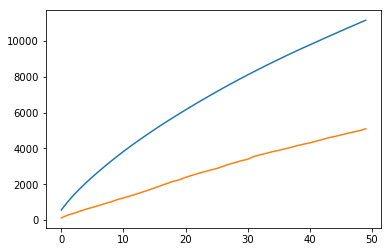

In [570]:
plt.plot(a.T.sum(axis=1))
plt.plot(b.T.sum(axis=1))
plt.show()

#### define function for getting real and pred results for each Label

In [572]:
def calculate_tracts(tracts_Label, Label_test):
    ## predicted crime numbers
    tracts_Label_edit = tracts_Label.T

    new_header = tracts_Label_edit.iloc[0] 
    tracts_Label_edit = tracts_Label_edit[1:] 
    tracts_Label_edit.columns = new_header

    tracts_Label_edit = tracts_Label_edit.rolling(window=26).mean()

    tracts_Label_edit = tracts_Label_edit[470:-2].T

    tracts_Label_edit = tracts_Label_edit / tracts_Label_edit.sum()

    Label_series = Label_test.iloc[52:,:].T

    new_header = Label_series.iloc[0] 
    Label_series = Label_series[1:] 
    Label_series.columns = new_header

    sum_Label = Label_series.iloc[1:]

    tracts_Label_pred = pd.DataFrame(tracts_Label_edit.values*sum_Label.values, 
                                      columns=tracts_Label_edit.columns, index=tracts_Label_edit.index)
    tracts_Label_pred['Total_1y'] = tracts_Label_pred.sum(axis=1)
    
    
    ## real crime numbers
    df1 = tracts_Label.iloc[:,:1]
    df2 = tracts_Label.iloc[:,471:-2]
    tracts_Label_real = pd.concat([df1, df2], axis=1)

    tracts_Label_real = tracts_Label_real.set_index('boro_ct201')
    tracts_Label_real['Total_1y_real'] = tracts_Label_real.sum(axis=1)
    return tracts_Label_real, tracts_Label_pred

In [577]:
real0, pred0 = calculate_tracts(tracts_Label0, Label0_test)
real1, pred1 = calculate_tracts(tracts_Label1, Label1_test)
real2, pred2 = calculate_tracts(tracts_Label2, Label2_test)
real3, pred3 = calculate_tracts(tracts_Label3, Label3_test)
real4, pred4 = calculate_tracts(tracts_Label4, Label4_test)

In [581]:
real_all = real0.append(real1)
real_all = real_all.append(real2)
real_all = real_all.append(real3)
real_all = real_all.append(real4)

In [583]:
pred_all = pred0.append(pred1)
pred_all = pred_all.append(pred2)
pred_all = pred_all.append(pred3)
pred_all = pred_all.append(pred4)

In [606]:
real_50, pred_50 = weekly_check(real_all, pred_all)

In [805]:
real_all.head()

,2017-01-02 00:00:00,2017-01-09 00:00:00,2017-01-16 00:00:00,2017-01-23 00:00:00,2017-01-30 00:00:00,2017-02-06 00:00:00,2017-02-13 00:00:00,2017-02-20 00:00:00,2017-02-27 00:00:00,2017-03-06 00:00:00,...,2017-10-23 00:00:00,2017-10-30 00:00:00,2017-11-06 00:00:00,2017-11-13 00:00:00,2017-11-20 00:00:00,2017-11-27 00:00:00,2017-12-04 00:00:00,2017-12-11 00:00:00,2017-12-18 00:00:00,Total_1y_real
boro_ct201,,,,,,,,,,,,,,,,,,,,,
1000800,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0,2.0,2.0,...,1.0,1.0,0.0,1.0,4.0,2.0,0.0,2.0,1.0,66.0
1002202,2.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,22.0
1002900,3.0,1.0,1.0,0.0,3.0,1.0,0.0,1.0,2.0,0.0,...,1.0,0.0,0.0,1.0,0.0,4.0,0.0,1.0,0.0,56.0
1004200,2.0,2.0,0.0,1.0,3.0,3.0,2.0,3.0,2.0,0.0,...,1.0,2.0,2.0,1.0,0.0,1.0,1.0,2.0,1.0,68.0
1005502,1.0,0.0,2.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,...,0.0,1.0,2.0,2.0,0.0,0.0,3.0,1.0,0.0,60.0


In [608]:
## make it csv
pred_50.to_csv('LSTM_pred_50')

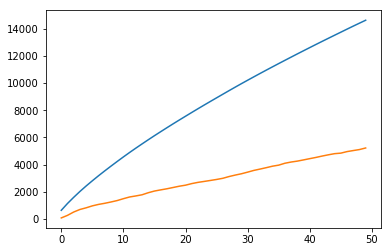

In [592]:
plt.plot(real_50.T.sum(axis=1))
plt.plot(pred_50.T.sum(axis=1))
plt.show()

#### Random Forest results

In [726]:
rf = pd.read_csv('df_y.csv')

In [727]:
rf_curve_real = rf.set_index('BoroCT2010')

In [728]:
rf = rf.T
rf = rf.rename(columns=rf.iloc[0])
rf = rf[1:]
rf['Total'] = rf.sum(axis=1)
rf = rf.reset_index(drop=True)

In [764]:
rf_pred = pd.read_csv('df_ypred.csv')

In [771]:
rf_curve_pred = rf_pred.set_index('BoroCT2010')

In [772]:
rf_curve_pred['Total'] = rf_curve_pred.sum(axis=1)

In [776]:
rf_curve_pred = rf_curve_pred.merge(df_op, left_index=True, right_on='boro_ct201')

In [778]:
rf_curve_pred = rf_curve_pred.set_index('boro_ct201')

In [814]:
rf_curve_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,Total,overpolicing
boro_ct201,,,,,,,,,,,,,,,,,,,,,
1000201,0.29,0.19,0.81,0.15,0.21,0.15,0.22,0.20,0.17,0.13,...,0.17,0.25,0.74,0.24,0.24,0.73,0.72,0.08,21.97,0.366013
1000600,2.31,2.00,1.81,1.80,0.72,1.71,2.36,0.72,1.84,3.67,...,1.94,2.45,3.17,2.55,1.85,1.38,1.88,2.17,97.07,1.872429
1000800,0.41,0.64,1.17,1.37,0.38,1.77,2.34,1.13,1.82,1.81,...,0.77,1.26,3.09,1.78,0.48,1.69,1.84,0.34,74.13,0.968030
1001200,0.65,0.91,1.01,1.18,0.74,0.72,0.86,0.83,0.65,0.72,...,1.10,0.66,0.82,0.87,0.95,0.88,0.92,0.86,47.42,2.030927
1001300,2.67,2.53,2.68,3.18,2.99,2.65,2.56,3.19,3.07,2.06,...,3.95,3.00,3.31,3.09,3.18,3.82,2.85,2.29,170.82,3.431374


In [806]:
rf_pred_op = pd.DataFrame(rf_curve_pred.iloc[:,:-2].values * rf_curve_pred.iloc[:,53:].values)

In [816]:
rf_pred_op.index = rf_curve_pred.index

In [817]:
rf_pred_op.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
boro_ct201,,,,,,,,,,,,,,,,,,,,,
1000201,0.106144,0.069543,0.296471,0.054902,0.076863,0.054902,0.080523,0.073203,0.062222,0.047582,...,0.248889,0.289150,0.062222,0.091503,0.270850,0.087843,0.087843,0.267190,0.263530,0.029281
1000600,4.325311,3.744858,3.389096,3.370372,1.348149,3.201853,4.418932,1.348149,3.445269,6.871814,...,3.482718,5.710908,3.632512,4.587451,5.935600,4.774694,3.463993,2.583952,3.520166,4.063171
1000800,0.396892,0.619539,1.132595,1.326201,0.367851,1.713413,2.265190,1.093874,1.761814,1.752134,...,1.335881,1.848937,0.745383,1.219718,2.991212,1.723093,0.464654,1.635971,1.781175,0.329130
1001200,1.320103,1.848144,2.051236,2.396494,1.502886,1.462268,1.746597,1.685670,1.320103,1.462268,...,2.335566,2.010618,2.234020,1.340412,1.665360,1.766907,1.929381,1.787216,1.868453,1.746597
1001300,9.161769,8.681377,9.196083,10.911770,10.259809,9.093142,8.784318,10.946084,10.534319,7.068631,...,16.573538,13.039222,13.553928,10.294123,11.357849,10.602946,10.911770,13.107850,9.779417,7.857847


In [823]:
## make it csv
rf_pred_op.to_csv('rf_pred_op.csv')

In [761]:
rf_pred = rf_pred.T
rf_pred = rf_pred.rename(columns=rf.iloc[0])
rf_pred = rf_pred[1:]
rf_pred['Total'] = rf_pred.sum(axis=1)

In [763]:
rf_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,1951,1952,1953,1954,1955,1956,1957,1958,1959,Total
0,0.29,1.61,0.02,2.31,1.30,0.41,1.39,0.00,0.82,0.65,...,0.11,0.87,0.84,0.66,0.16,0.22,0.91,0.80,0.86,1641.30
1,0.19,0.29,0.00,2.00,1.20,0.64,1.35,0.01,0.23,0.91,...,0.71,1.99,0.22,0.75,0.08,0.45,0.31,0.19,0.76,1623.41
2,0.81,1.52,0.01,1.81,1.36,1.17,1.74,0.04,1.00,1.01,...,0.15,3.72,0.22,0.94,0.13,0.24,0.88,0.98,0.93,1843.31
3,0.15,0.95,0.00,1.80,0.53,1.37,1.42,0.03,0.22,1.18,...,0.08,0.88,0.18,0.70,0.12,0.90,0.15,0.87,0.75,1739.49
4,0.21,0.86,0.00,0.72,3.13,0.38,1.62,0.01,0.22,0.74,...,0.08,1.58,0.75,0.80,0.07,0.46,0.17,0.25,0.71,1665.87


In [ ]:
rf_pred = rf_pred.reset_index(drop=True)

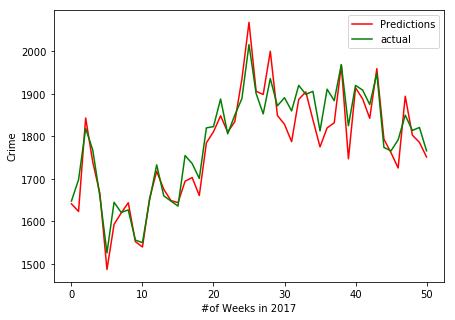

In [732]:
plt.figure(figsize=(7, 5))
plt.plot(rf_pred.iloc[:-1,:].index, rf_pred.iloc[:-1,:].Total, label='Predictions', color='red')
plt.plot(rf.iloc[:-1,:].index, rf.iloc[:-1,:].Total, label='actual', color='green')
plt.xlabel("#of Weeks in 2017")
plt.ylabel("Crime")
#plt.title(title)
plt.legend()
plt.show()

In [733]:
rf_real_50, rf_pred_50 = weekly_check(rf_curve_real, rf_curve_pred)

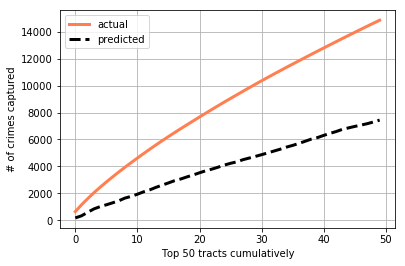

In [746]:
plt.plot(rf_real_50.T.sum(axis=1), color='coral', linewidth=3, label='actual')
plt.plot(rf_pred_50.T.sum(axis=1), 'k--', linewidth=3, label='predicted')
plt.ylabel('# of crimes captured')
plt.xlabel('Top 50 tracts cumulatively')
plt.legend(loc='upper left')
plt.grid(True)

In [818]:
rf_real_50, rf_pred_50_op = weekly_check(rf_curve_real, rf_pred_op)

In [822]:
rf_pred_50_op.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,20.862755,20.862755,...,182.782272,182.782272,191.076631,191.076631,198.946474,198.946474,198.946474,206.471627,206.471627,216.546035
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,112.528580,112.528580,112.528580,112.528580,112.528580,112.528580,112.528580,112.528580,127.592462,134.978496
2,0.0,0.0,0.0,0.0,24.575960,24.575960,24.575960,24.575960,24.575960,24.575960,...,204.204498,204.204498,204.204498,204.204498,221.800583,221.800583,221.800583,230.209061,230.209061,230.209061
3,0.0,0.0,0.0,0.0,0.000000,33.382904,33.382904,52.326842,52.326842,52.326842,...,164.306221,164.306221,164.306221,164.306221,173.016180,173.016180,173.016180,173.016180,181.580890,181.580890
4,0.0,0.0,0.0,0.0,30.980988,30.980988,30.980988,30.980988,30.980988,30.980988,...,113.941943,113.941943,113.941943,113.941943,113.941943,138.848001,147.651494,155.627951,155.627951,155.627951


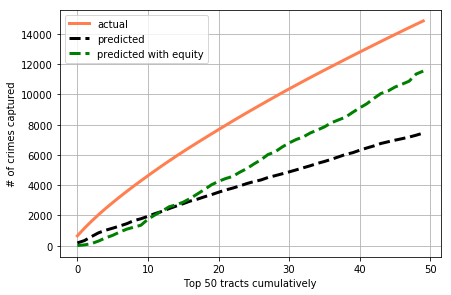

In [828]:
fig = plt.figure(figsize = (15,10))

ax1 = fig.add_subplot(221)
ax1.plot(rf_real_50.T.sum(axis=1), color='coral', linewidth=3, label='actual')
ax1.plot(rf_pred_50.T.sum(axis=1), 'k--', color='black', linewidth=3, label='predicted')
ax1.plot(rf_pred_50_op.T.sum(axis=1), 'k--', color='green', linewidth=3, label='predicted with equity')
plt.ylabel('# of crimes captured')
plt.xlabel('Top 50 tracts cumulatively')
plt.legend(loc='upper left')
plt.grid(True)

# ax2 = fig.add_subplot(222)
# ax2.plot(rf_real_50.T.sum(axis=1), color='coral', linewidth=3, label='actual')
# ax2.plot(rf_pred_50_op.T.sum(axis=1), 'k--', linewidth=3, label='predicted')
# plt.ylabel('# of crimes captured')
# plt.xlabel('Top 50 tracts cumulatively')
# plt.legend(loc='upper left')
# plt.grid(True)

#### add overpolicing

In [748]:
df_op.head()

,boro_ct201,overpolicing
0,4046200,1.632706
1,4045000,1.486929
2,4045400,0.644933
3,4045500,1.903269
4,4045600,1.840960


In [753]:
rf.T.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
1000201.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1000202.0,2.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,...,0.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0
1000500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000600.0,3.0,2.0,2.0,2.0,0.0,2.0,3.0,0.0,2.0,5.0,...,2.0,4.0,2.0,3.0,5.0,3.0,2.0,1.0,2.0,3.0
1000700.0,1.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,0.0,4.0,...,1.0,0.0,2.0,1.0,1.0,0.0,2.0,3.0,2.0,0.0


In [756]:
rf_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,1951,1952,1953,1954,1955,1956,1957,1958,1959,Total
0,0.29,1.61,0.02,2.31,1.30,0.41,1.39,0.00,0.82,0.65,...,0.11,0.87,0.84,0.66,0.16,0.22,0.91,0.80,0.86,1641.30
1,0.19,0.29,0.00,2.00,1.20,0.64,1.35,0.01,0.23,0.91,...,0.71,1.99,0.22,0.75,0.08,0.45,0.31,0.19,0.76,1623.41
2,0.81,1.52,0.01,1.81,1.36,1.17,1.74,0.04,1.00,1.01,...,0.15,3.72,0.22,0.94,0.13,0.24,0.88,0.98,0.93,1843.31
3,0.15,0.95,0.00,1.80,0.53,1.37,1.42,0.03,0.22,1.18,...,0.08,0.88,0.18,0.70,0.12,0.90,0.15,0.87,0.75,1739.49
4,0.21,0.86,0.00,0.72,3.13,0.38,1.62,0.01,0.22,0.74,...,0.08,1.58,0.75,0.80,0.07,0.46,0.17,0.25,0.71,1665.87


In [758]:
rf_curve_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
BoroCT2010,,,,,,,,,,,,,,,,,,,,,
1000201,0.29,0.19,0.81,0.15,0.21,0.15,0.22,0.20,0.17,0.13,...,0.68,0.79,0.17,0.25,0.74,0.24,0.24,0.73,0.72,0.08
1000202,1.61,0.29,1.52,0.95,0.86,0.20,0.20,0.82,1.46,0.79,...,0.22,0.25,0.97,1.91,0.32,0.85,0.17,0.76,0.16,0.80
1000500,0.02,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.01,...,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.00
1000600,2.31,2.00,1.81,1.80,0.72,1.71,2.36,0.72,1.84,3.67,...,1.86,3.05,1.94,2.45,3.17,2.55,1.85,1.38,1.88,2.17
1000700,1.30,1.20,1.36,0.53,3.13,1.08,1.78,1.89,0.63,3.05,...,1.17,0.78,1.68,1.18,1.19,0.62,1.97,2.07,1.81,0.45


#### ---- going on from previous section way above---- 

In [189]:
tract_Label1_predVSreal = tracts_Label1_pred[['Total_1y']].merge(tracts_Label1_real[['Total_1y_real']], 
                                                                 left_index=True, right_index=True)

In [190]:
tract_Label1_predVSreal = tract_Label1_predVSreal.sort_values(by='Total_1y_real', ascending=False)

In [191]:
tract_Label1_predVSreal['real_cum'] = tract_Label1_predVSreal.Total_1y_real.cumsum()

In [192]:
tract_Label1_predVSreal['pred_cum'] = tract_Label1_predVSreal.Total_1y.cumsum()

In [193]:
tract_Label1_predVSreal['real_cum_perc'] = tract_Label1_predVSreal.real_cum / max(tract_Label1_predVSreal.real_cum) 

In [194]:
tract_Label1_predVSreal['pred_cum_perc'] = tract_Label1_predVSreal.pred_cum / max(tract_Label1_predVSreal.pred_cum)

In [195]:
tract_Label1_predVSreal = tract_Label1_predVSreal.reset_index()

In [196]:
tract_Label1_predVSreal['index_perc'] = ( ((tract_Label1_predVSreal.index.values)+1) 
                                        / max((tract_Label1_predVSreal.index.values)+1) )

In [197]:
tract_Label1_predVSreal.head()

,boro_ct201,Total_1y,Total_1y_real,real_cum,pred_cum,real_cum_perc,pred_cum_perc,index_perc
0,2000100.0,394.682493,372.0,372.0,394.682493,0.015019,0.015885,0.002571
1,2006500.0,337.450251,345.0,717.0,732.132744,0.028949,0.029467,0.005141
2,1010400.0,237.128780,259.0,976.0,969.261524,0.039406,0.039010,0.007712
3,1011402.0,231.894230,246.0,1222.0,1201.155754,0.049338,0.048344,0.010283
4,1012100.0,242.211364,240.0,1462.0,1443.367118,0.059028,0.058092,0.012853


In [204]:
tract_Label1_predVSreal[:50].Total_1y_real.sum() / tract_Label1_predVSreal.Total_1y_real.sum() 

0.34786821705426357

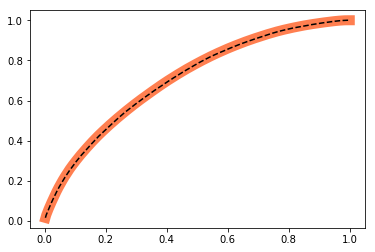

In [221]:
plt.figure()
plt.plot(tract_Label1_predVSreal.index_perc, tract_Label1_predVSreal.real_cum_perc, color='coral', linewidth=10)
plt.plot(tract_Label1_predVSreal.index_perc, tract_Label1_predVSreal.pred_cum_perc, 'k--')
plt.show()

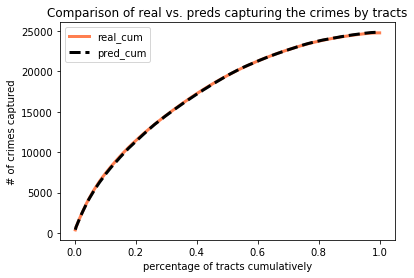

In [348]:
plt.figure()
plt.plot(tract_Label1_predVSreal.index_perc, tract_Label1_predVSreal.real_cum, color='coral', linewidth=3)
plt.plot(tract_Label1_predVSreal.index_perc, tract_Label1_predVSreal.pred_cum, 'k--', linewidth=3)
plt.title('Comparison of real vs. preds capturing the crimes by tracts')
plt.ylabel('# of crimes captured')
plt.xlabel('percentage of tracts cumulatively')
plt.legend(loc='upper left')
plt.show()

#### define function to calculate tracts

In [223]:
def calculate_tracts(tracts_Label, Label_test):
    
    tracts_Label_edit = tracts_Label.T

    new_header = tracts_Label_edit.iloc[0] 
    tracts_Label_edit = tracts_Label_edit[1:] 
    tracts_Label_edit.columns = new_header

    tracts_Label_edit = tracts_Label_edit.rolling(window=26).mean()

    tracts_Label_edit = tracts_Label_edit[470:-2].T

    tracts_Label_edit = tracts_Label_edit / tracts_Label_edit.sum()

    Label_series = Label_test.iloc[52:,:].T

    new_header = Label_series.iloc[0] 
    Label_series = Label_series[1:] 
    Label_series.columns = new_header

    sum_Label = Label_series.iloc[1:]

    tracts_Label_pred = pd.DataFrame(tracts_Label_edit.values*sum_Label.values, 
                                      columns=tracts_Label_edit.columns, index=tracts_Label_edit.index)

    tracts_Label_pred['Total_1y'] = tracts_Label_pred.sum(axis=1)

    df1 = tracts_Label.iloc[:,:1]
    df2 = tracts_Label.iloc[:,471:-2]
    tracts_Label_real = pd.concat([df1, df2], axis=1)

    tracts_Label_real = tracts_Label_real.set_index('boro_ct201')
    tracts_Label_real['Total_1y_real'] = tracts_Label_real.sum(axis=1)

    tract_Label_predVSreal = tracts_Label_pred[['Total_1y']].merge(tracts_Label_real[['Total_1y_real']], 
                                                                     left_index=True, right_index=True)
    tract_Label_predVSreal = tract_Label_predVSreal.sort_values(by='Total_1y_real', ascending=False)
    tract_Label_predVSreal['real_cum'] = tract_Label_predVSreal.Total_1y_real.cumsum()
    tract_Label_predVSreal['pred_cum'] = tract_Label_predVSreal.Total_1y.cumsum()
    tract_Label_predVSreal['real_cum_perc'] = tract_Label_predVSreal.real_cum / max(tract_Label_predVSreal.real_cum) 
    tract_Label_predVSreal['pred_cum_perc'] = tract_Label_predVSreal.pred_cum / max(tract_Label_predVSreal.pred_cum)
    tract_Label_predVSreal = tract_Label_predVSreal.reset_index()
    tract_Label_predVSreal['index_perc'] = ( ((tract_Label_predVSreal.index.values)+1) 
                                            / max((tract_Label_predVSreal.index.values)+1) )

    return tract_Label_predVSreal

### Label0

In [231]:
tract_Label0_predVSreal = calculate_tracts(tracts_Label0, Label0_test)

In [233]:
tract_Label0_predVSreal.head()

,boro_ct201,Total_1y,Total_1y_real,real_cum,pred_cum,real_cum_perc,pred_cum_perc,index_perc
0,1011500.0,227.686968,222.0,222.0,227.686968,0.018422,0.017326,0.002639
1,1018300.0,164.446255,151.0,373.0,392.133223,0.030952,0.029840,0.005277
2,1018900.0,152.659657,143.0,516.0,544.792880,0.042818,0.041457,0.007916
3,1022900.0,132.281692,123.0,639.0,677.074571,0.053025,0.051524,0.010554
4,1024500.0,124.857261,118.0,757.0,801.931832,0.062816,0.061025,0.013193


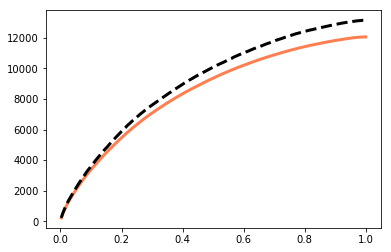

In [248]:
plt.figure()
plt.plot(tract_Label0_predVSreal.index_perc, tract_Label0_predVSreal.real_cum, color='coral', linewidth=3)
plt.plot(tract_Label0_predVSreal.index_perc, tract_Label0_predVSreal.pred_cum, 'k--', linewidth=3)
plt.show()

### Label2

In [240]:
tract_Label2_predVSreal = calculate_tracts(tracts_Label2, Label2_test)

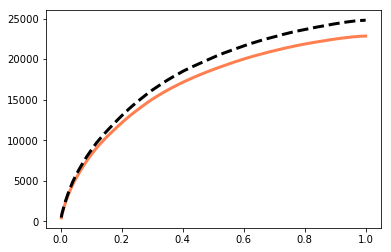

In [247]:
plt.figure()
plt.plot(tract_Label2_predVSreal.index_perc, tract_Label2_predVSreal.real_cum, color='coral', linewidth=3)
plt.plot(tract_Label2_predVSreal.index_perc, tract_Label2_predVSreal.pred_cum, 'k--', linewidth=3)
plt.show()

### Label3

In [250]:
tract_Label3_predVSreal = calculate_tracts(tracts_Label3, Label3_test)

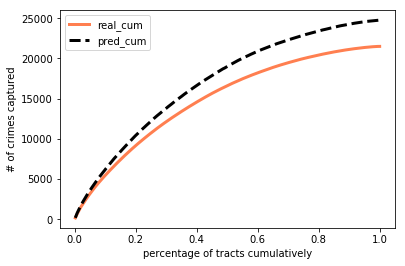

In [372]:
plt.figure()
plt.plot(tract_Label3_predVSreal.index_perc, tract_Label3_predVSreal.real_cum, color='coral', linewidth=3)
plt.plot(tract_Label3_predVSreal.index_perc, tract_Label3_predVSreal.pred_cum, 'k--', linewidth=3)
#plt.title('Comparison of real vs. preds capturing the crimes by tracts')
plt.ylabel('# of crimes captured')
plt.xlabel('percentage of tracts cumulatively')
plt.legend(loc='upper left')
plt.show()

### Label4

In [252]:
tract_Label4_predVSreal = calculate_tracts(tracts_Label4, Label4_test)

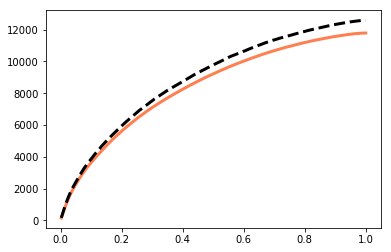

In [253]:
plt.figure()
plt.plot(tract_Label4_predVSreal.index_perc, tract_Label4_predVSreal.real_cum, color='coral', linewidth=3)
plt.plot(tract_Label4_predVSreal.index_perc, tract_Label4_predVSreal.pred_cum, 'k--', linewidth=3)
plt.show()

### Whole together

In [265]:
whole_tracts_pred = tract_Label0_predVSreal.iloc[:,:3].append(tract_Label1_predVSreal.iloc[:,:3])
whole_tracts_pred = whole_tracts_pred.append(tract_Label2_predVSreal.iloc[:,:3])
whole_tracts_pred = whole_tracts_pred.append(tract_Label3_predVSreal.iloc[:,:3])
whole_tracts_pred = whole_tracts_pred.append(tract_Label4_predVSreal.iloc[:,:3])

In [266]:
whole_tracts_pred = whole_tracts_pred.sort_values(by='Total_1y_real', ascending=False)

In [268]:
whole_tracts_pred['real_cum'] = whole_tracts_pred.Total_1y_real.cumsum()
whole_tracts_pred['pred_cum'] = whole_tracts_pred.Total_1y.cumsum()

In [271]:
whole_tracts_pred = whole_tracts_pred.reset_index().drop(['index'], axis=1)
whole_tracts_pred['index_perc'] = ( ((whole_tracts_pred.index.values)+1) 
                                            / max((whole_tracts_pred.index.values)+1) )

In [272]:
whole_tracts_pred.head()

,boro_ct201,Total_1y,Total_1y_real,real_cum,pred_cum,index_perc
0,1010900.0,465.241584,420.0,420.0,465.241584,0.000463
1,1011900.0,430.052174,390.0,810.0,895.293759,0.000926
2,2000100.0,394.682493,372.0,1182.0,1289.976252,0.001389
3,2006500.0,337.450251,345.0,1527.0,1627.426503,0.001852
4,1005200.0,288.207769,278.0,1805.0,1915.634272,0.002315


In [379]:
print('RMSE for whole:', ((whole_tracts_pred.Total_1y - whole_tracts_pred.Total_1y_real) ** 2).mean() ** .5)

RMSE for whole: 6.494344682437065


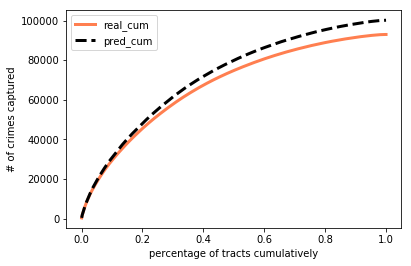

In [387]:
plt.figure()
plt.plot(whole_tracts_pred.index_perc, whole_tracts_pred.real_cum, color='coral', linewidth=3)
plt.plot(whole_tracts_pred.index_perc, whole_tracts_pred.pred_cum, 'k--', linewidth=3)
plt.ylabel('# of crimes captured')
plt.xlabel('percentage of tracts cumulatively')
plt.legend(loc='upper left')
plt.show()

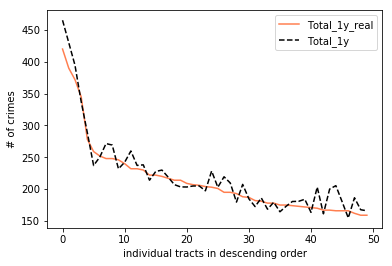

In [388]:
plt.figure()
plt.plot(whole_tracts_pred.index[:50], whole_tracts_pred.Total_1y_real[:50], color='coral')
plt.plot(whole_tracts_pred.index[:50], whole_tracts_pred.Total_1y[:50], 'k--')
plt.ylabel('# of crimes')
plt.xlabel('individual tracts in descending order')
plt.legend(loc='upper right')
plt.show()

### incorporating overpolicing

In [274]:
df_op = pd.read_csv('df_op.csv')

In [277]:
df_op = df_op.drop(['Unnamed: 0'], axis=1)

In [282]:
tracts_with_op = whole_tracts_pred.merge(df_op, left_on='boro_ct201', right_on='boro_ct201')

In [284]:
tracts_with_op['Total_1y_op'] = tracts_with_op.Total_1y * tracts_with_op.overpolicing 

In [286]:
tracts_with_op['pred_cum_op'] = tracts_with_op.Total_1y_op.cumsum()

In [292]:
tracts_with_op['real_cum_perc'] = tracts_with_op.real_cum / max(tracts_with_op.real_cum) 
tracts_with_op['pred_cum_op_perc'] = tracts_with_op.pred_cum_op / max(tracts_with_op.pred_cum_op)

In [298]:
tracts_with_op['pred_cum_perc'] = tracts_with_op.pred_cum / max(tracts_with_op.pred_cum)

In [299]:
tracts_with_op.head()

,boro_ct201,Total_1y,Total_1y_real,real_cum,pred_cum,index_perc,overpolicing,Total_1y_op,pred_cum_op,real_cum_perc,pred_cum_op_perc,pred_cum_perc
0,1010900.0,465.241584,420.0,420.0,465.241584,0.000463,1.025468,477.090433,477.090433,0.004518,0.002616,0.004646
1,1011900.0,430.052174,390.0,810.0,895.293759,0.000926,0.524376,225.508983,702.599417,0.008714,0.003852,0.008941
2,2000100.0,394.682493,372.0,1182.0,1289.976252,0.001389,1.591642,628.193286,1330.792702,0.012716,0.007296,0.012883
3,2006500.0,337.450251,345.0,1527.0,1627.426503,0.001852,0.523698,176.722092,1507.514794,0.016427,0.008265,0.016253
4,1005200.0,288.207769,278.0,1805.0,1915.634272,0.002315,2.849947,821.376849,2328.891643,0.019418,0.012769,0.019131


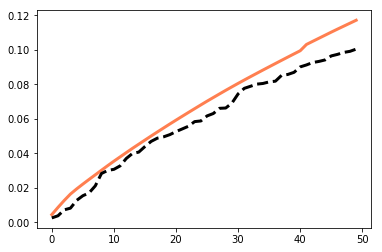

In [385]:
plt.figure()
plt.plot(tracts_with_op.index[:50], tracts_with_op.real_cum_perc[:50], color='coral', linewidth=3)
plt.plot(tracts_with_op.index[:50], tracts_with_op.pred_cum_op_perc[:50], 'k--', linewidth=3)
plt.show()

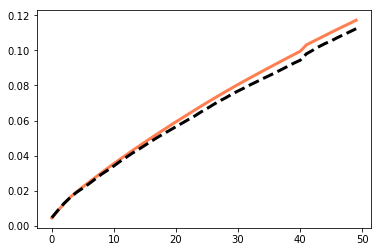

In [386]:
plt.figure()
plt.plot(tracts_with_op.index[:50], tracts_with_op.real_cum_perc[:50], color='coral', linewidth=3)
plt.plot(tracts_with_op.index[:50], tracts_with_op.pred_cum_perc[:50], 'k--', linewidth=3)
plt.show()

In [303]:
tracts_with_op.to_csv('tracts_pred_with_op')

In [304]:
tracts_with_op.head()

,boro_ct201,Total_1y,Total_1y_real,real_cum,pred_cum,index_perc,overpolicing,Total_1y_op,pred_cum_op,real_cum_perc,pred_cum_op_perc,pred_cum_perc
0,1010900.0,465.241584,420.0,420.0,465.241584,0.000463,1.025468,477.090433,477.090433,0.004518,0.002616,0.004646
1,1011900.0,430.052174,390.0,810.0,895.293759,0.000926,0.524376,225.508983,702.599417,0.008714,0.003852,0.008941
2,2000100.0,394.682493,372.0,1182.0,1289.976252,0.001389,1.591642,628.193286,1330.792702,0.012716,0.007296,0.012883
3,2006500.0,337.450251,345.0,1527.0,1627.426503,0.001852,0.523698,176.722092,1507.514794,0.016427,0.008265,0.016253
4,1005200.0,288.207769,278.0,1805.0,1915.634272,0.002315,2.849947,821.376849,2328.891643,0.019418,0.012769,0.019131


### mapping

In [306]:
import geopandas as gpd
import shapely
from fiona.crs import from_epsg

In [307]:
census_track = gpd.GeoDataFrame.from_file("geo_export_528e5298-ab8f-4cf6-b6ad-de2f22d1f1a0.shp")
census_track.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,POLYGON ((-74.07920577013245 40.64343078374567...
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,POLYGON ((-73.96432543478758 40.75638153099091...
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,POLYGON ((-73.96802436915851 40.75957814005282...
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...


In [308]:
census_track.crs = from_epsg(4326)
census_track.crs

{'init': 'epsg:4326', 'no_defs': True}

In [321]:
census_track['ct2010'] = pd.to_numeric(census_track.boro_ct201)

In [324]:
tracts_gpd = census_track.merge(tracts_with_op, left_on='ct2010', right_on='boro_ct201')

In [328]:
tracts_gpd = tracts_gpd.iloc[:,11:]

In [329]:
tracts_gpd.head()

,geometry,boro_ct201_y,Total_1y,Total_1y_real,real_cum,pred_cum,index_perc,overpolicing,Total_1y_op,pred_cum_op,real_cum_perc,pred_cum_op_perc,pred_cum_perc
0,POLYGON ((-74.07920577013245 40.64343078374567...,5000900.0,22.860877,20.0,84738.0,90762.803463,0.687037,1.349482,30.850333,165271.138525,0.911612,0.906140,0.906431
1,POLYGON ((-73.96432543478758 40.75638153099091...,1009800.0,91.573574,91.0,27727.0,29029.669661,0.091204,2.070038,189.560794,61217.791641,0.298287,0.335642,0.289914
2,POLYGON ((-73.96802436915851 40.75957814005282...,1010000.0,157.864012,155.0,11044.0,11405.046987,0.024074,0.339869,53.653155,18367.651163,0.118811,0.100705,0.113900
3,POLYGON ((-73.97124277307127 40.76093641847906...,1010200.0,63.638874,62.0,47289.0,49994.036517,0.212963,1.897116,120.730332,97759.176771,0.508736,0.535989,0.499281
4,POLYGON ((-73.97445730550224 40.76229308352487...,1010400.0,237.128780,259.0,2064.0,2152.763052,0.002778,2.072689,491.494140,2820.385783,0.022205,0.015463,0.021499


In [ ]:
from matplotlib import cm
fig = plt.figure(figsize = (15,7))

ax1 = fig.add_subplot(121)
pumashp.plot(color='gray', ax=ax1, edgecolor='black')
alldata_map.plot(column='SATmath',cmap='Blues', alpha=1,
                  lw=1, ax=ax1, scheme="Equal_interval", edgecolor="black", legend=True, k=5)
leg = ax1.get_legend()
leg.set_bbox_to_anchor((0., 0., 0.35, 1))
plt.title('SATmath score distribution')
plt.ylabel('Longitudes')
plt.xlabel('Latitudes')

ax2 = fig.add_subplot(122)
pumashp.plot(color='gray', ax=ax2, edgecolor='black')
alldata_map.plot(column='SATall',cmap='Blues', alpha=1,
                  lw=1, ax=ax2, scheme="Equal_interval", edgecolor="black", legend=True, k=5)
leg = ax2.get_legend()
leg.set_bbox_to_anchor((0., 0., 0.35, 1))
plt.title('SATall score distribution')
plt.ylabel('Longitudes')
plt.xlabel('Latitudes')
plt.show()